# Pipeline example: mortality, fertility, emigration and immigration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import FertilityAgeSpecificRates
from vivarium_public_health.population import Mortality
from vivarium_public_health.population import Emigration
from vivarium_public_health.population import ImmigrationDeterministic as Immigration

from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset
from vivarium_public_health.population.spenser_population import compute_migration_rates

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_mortality_file': inp_file['paths']['path_to_mortality_file'],
        'path_to_fertility_file': inp_file['paths']['path_to_fertility_file'],
        'path_to_emigration_file': inp_file['paths']['path_to_emigration_file'],
        'path_to_immigration_file': inp_file['paths']['path_to_immigration_file'],
        'path_to_total_population_file': inp_file['paths']['path_to_total_population_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification_pipeline_005.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [5]:
components

 FertilityAgeSpecificRates(),
 Emigration(),
 ImmigrationDeterministic(),
 Mortality()]

In [6]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data = transform_rate_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

In [7]:
mortality_rate_df.head()

,Unnamed: 0,LAD.name,LAD.code,ETH.group,MB.0,M0.1,M1.2,M2.3,M3.4,M4.5,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,2,Barking and Dagenham,E09000002,WBI,0.003326,0.001683,0.000409,0.000261,0.000211,0.000194,...,0.164990,0.183852,0.204869,0.228290,0.254387,0.283468,0.315874,0.351984,0.392222,0.437060
390,391,Barking and Dagenham,E09000002,WHO,0.003453,0.001731,0.000405,0.000257,0.000197,0.000190,...,0.157919,0.176068,0.196304,0.218865,0.244019,0.272064,0.303332,0.338194,0.377062,0.420398
779,780,Barking and Dagenham,E09000002,MIX,0.003569,0.001777,0.000405,0.000264,0.000202,0.000190,...,0.159100,0.177560,0.198162,0.221154,0.246813,0.275450,0.307410,0.343078,0.382884,0.427309
1168,1169,Barking and Dagenham,E09000002,IND,0.003921,0.001948,0.000426,0.000262,0.000205,0.000206,...,0.155810,0.173602,0.193426,0.215513,0.240123,0.267543,0.298094,0.332133,0.370060,0.412317
1557,1558,Barking and Dagenham,E09000002,PAK,0.004396,0.002163,0.000434,0.000272,0.000222,0.000201,...,0.165502,0.183895,0.204332,0.227041,0.252273,0.280309,0.311462,0.346076,0.384537,0.427273


## Fertility rates


In [8]:
df = pd.read_csv(config.path_to_fertility_file)
# to save time, only look at locatiosn existing on the test dataset.
fertility_rate_df = df[(df['LAD.code']=='E09000002')]

asfr_data_fertility = transform_rate_table(fertility_rate_df,
                                      2011,
                                      2012,
                                      10,  # starting age for fertility
                                      50,  # finishing age for fertility
                                      [2]) # gender (only females [2])


simulation._data.write("covariate.age_specific_fertility_rate.estimate", asfr_data_fertility)


In [9]:
asfr_data_fertility.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,11,10,BAN,E09000002,0.001371,2,2012,2011
1,12,11,BAN,E09000002,0.005288,2,2012,2011
2,13,12,BAN,E09000002,0.018091,2,2012,2011
3,14,13,BAN,E09000002,0.031652,2,2012,2011
4,15,14,BAN,E09000002,0.050201,2,2012,2011


In [10]:
fertility_rate_df.head()

,LAD.name,LAD.code,ETH.group,F10.11,F11.12,F12.13,F13.14,F14.15,F15.16,F16.17,...,F91.92,F92.93,F93.94,F94.95,F95.96,F96.97,F97.98,F98.99,F99.100,F100.101p
1,Barking and Dagenham,E09000002,WBI,0.000026,0.000234,0.001569,0.003613,0.007285,0.013133,0.021530,...,0,0,0,0,0,0,0,0,0,0
390,Barking and Dagenham,E09000002,WHO,0.000029,0.000263,0.001764,0.004062,0.008189,0.014764,0.024203,...,0,0,0,0,0,0,0,0,0,0
779,Barking and Dagenham,E09000002,MIX,0.000001,0.000023,0.000294,0.000872,0.002184,0.004742,0.009128,...,0,0,0,0,0,0,0,0,0,0
1168,Barking and Dagenham,E09000002,IND,0.000012,0.000153,0.001286,0.003223,0.006976,0.013354,0.023028,...,0,0,0,0,0,0,0,0,0,0
1557,Barking and Dagenham,E09000002,PAK,0.001265,0.004877,0.016688,0.029197,0.046309,0.067626,0.092084,...,0,0,0,0,0,0,0,0,0,0


In [11]:
simulation.name

'simulation_context'

## Emigration

In [12]:
# setup emigration rates
df_emigration = pd.read_csv(config.path_to_emigration_file)
df_total_population = pd.read_csv(config.path_to_total_population_file)

df_emigration = df_emigration[
    (df_emigration['LAD.code'] == 'E09000002')]
df_total_population = df_total_population[
    (df_total_population['LAD'] == 'E09000002')]

asfr_data_emigration = compute_migration_rates(df_emigration, df_total_population, 
                                               2011, 
                                               2012, 
                                               config.population.age_start, 
                                               config.population.age_end, aggregate_over=75)

In [13]:
asfr_data_emigration.head()

,age_end,age_start,ethnicity,location,mean_value,sex,year_end,year_start
0,1,0,BAN,E09000002,0.000000,1,2012,2011
1,2,1,BAN,E09000002,0.002178,1,2012,2011
2,3,2,BAN,E09000002,0.000000,1,2012,2011
3,4,3,BAN,E09000002,0.000000,1,2012,2011
4,5,4,BAN,E09000002,0.000000,1,2012,2011


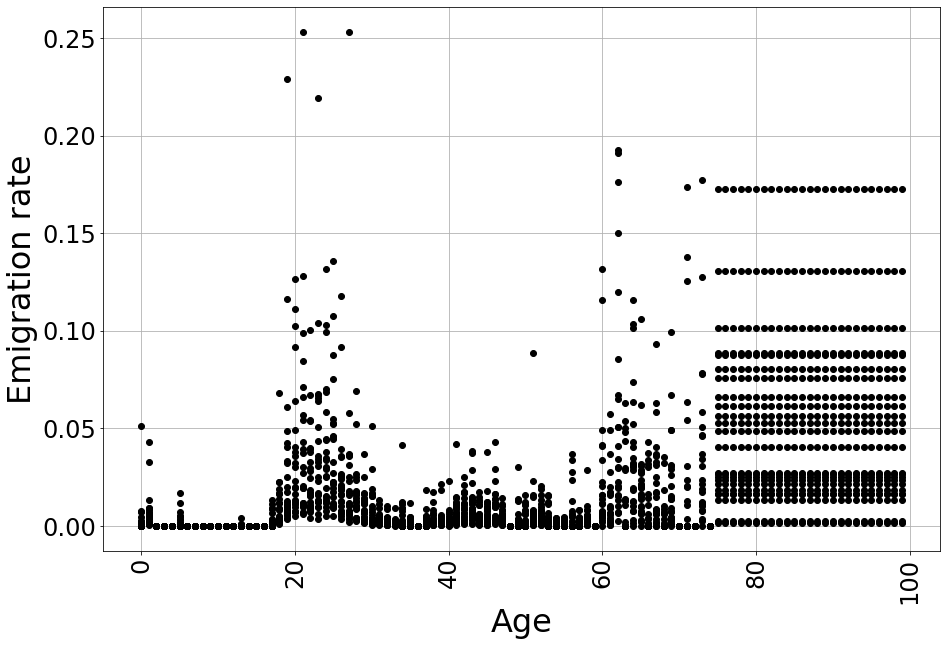

In [14]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_emigration["age_start"], 
         asfr_data_emigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Emigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [15]:
simulation._data.write("covariate.age_specific_migration_rate.estimate", asfr_data_emigration)

## Immigration rates

In [16]:
# setup immigration rates
df_immigration = pd.read_csv(config.path_to_immigration_file)

df_immigration = df_immigration[
    (df_immigration['LAD.code'] == 'E09000002')]

asfr_data_immigration = compute_migration_rates(df_immigration, df_total_population, 
                                                2011, 
                                                2012, 
                                                config.population.age_start, 
                                                config.population.age_end,
                                                normalize=False
                                               )

In [17]:
# TESTING
# asfr_data_immigration.loc[asfr_data_immigration["age_start"] > 80, "mean_value"] = 100
asfr_data_immigration["mean_value"].describe()

count    2400.000000
mean        1.081231
std         3.195961
min         0.000000
25%         0.000000
50%         0.105836
75%         0.667866
max        34.451292
Name: mean_value, dtype: float64

In [18]:
# XXX CHECK!!!
total_immigrants = df_immigration[df_immigration.columns[4:]].sum().sum()

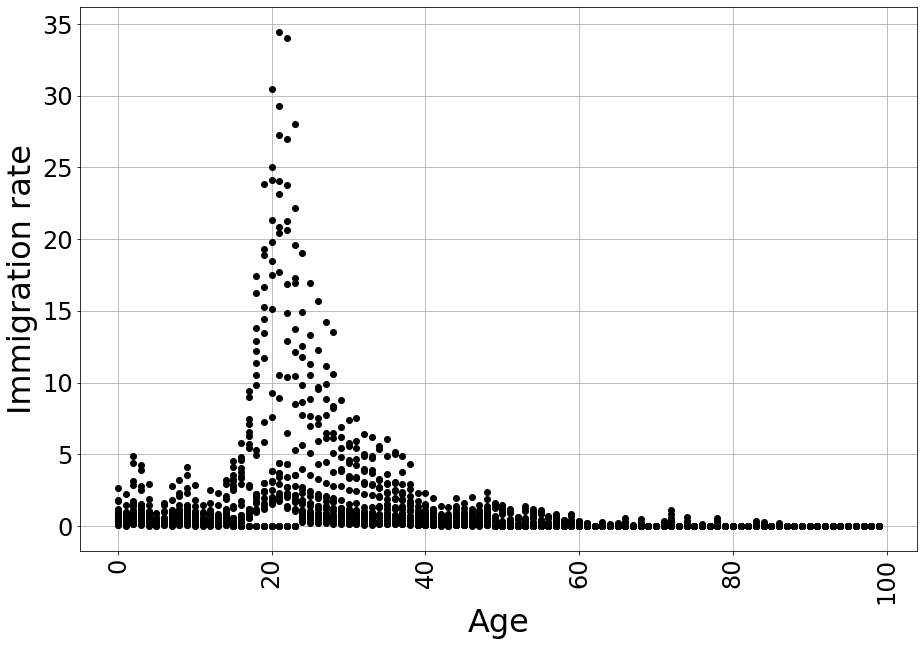

In [19]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(asfr_data_immigration["age_start"], 
         asfr_data_immigration["mean_value"], 
         '.', c='k', lw=4, markersize=12)
plt.xlabel("Age", size=32)
plt.ylabel("Immigration rate", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

In [20]:
simulation._data.write("cause.all_causes.cause_specific_immigration_rate", asfr_data_immigration)
simulation._data.write("cause.all_causes.cause_specific_total_immigrants_per_year", total_immigrants)

## Setup a simulation and run for `num_days`

In [21]:
sim_start = time.time()

simulation.setup()
num_days = 365*10 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-07-23 16:50:24.554 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-07-23 16:50:25.408 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline fertility rate
2020-07-23 16:50:29.543 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline emigration_rate
2020-07-23 16:50:33.475 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-07-23 16:50:33.476 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-07-23 16:51:17.266 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-07-23 16:51:56.251 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-07-23 16:52:38.602 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-07-23 16:53:13.451 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-07-23 16:54:09.350 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-07-23 16:54:50.243 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-07-23 16:55:27.129 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-07-23 16:56:00.209 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-07-23 16:56:37.046 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-07-23 16:57:03.509 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-07-23 16:57:43.558 | DEBUG    | vivarium.framework.engi

2020-07-23 17:48:53.269 | DEBUG    | vivarium.framework.engine:step:140 - 2013-05-30 00:00:00
2020-07-23 17:49:32.799 | DEBUG    | vivarium.framework.engine:step:140 - 2013-06-09 00:00:00
2020-07-23 17:50:24.606 | DEBUG    | vivarium.framework.engine:step:140 - 2013-06-19 00:00:00
2020-07-23 17:51:00.138 | DEBUG    | vivarium.framework.engine:step:140 - 2013-06-29 00:00:00
2020-07-23 17:51:56.280 | DEBUG    | vivarium.framework.engine:step:140 - 2013-07-09 00:00:00
2020-07-23 17:52:32.265 | DEBUG    | vivarium.framework.engine:step:140 - 2013-07-19 00:00:00
2020-07-23 17:53:07.779 | DEBUG    | vivarium.framework.engine:step:140 - 2013-07-29 00:00:00
2020-07-23 17:53:55.635 | DEBUG    | vivarium.framework.engine:step:140 - 2013-08-08 00:00:00
2020-07-23 17:54:38.914 | DEBUG    | vivarium.framework.engine:step:140 - 2013-08-18 00:00:00
2020-07-23 17:55:18.366 | DEBUG    | vivarium.framework.engine:step:140 - 2013-08-28 00:00:00
2020-07-23 17:56:06.025 | DEBUG    | vivarium.framework.engi

2020-07-23 18:54:20.871 | DEBUG    | vivarium.framework.engine:step:140 - 2015-10-27 00:00:00
2020-07-23 18:55:00.899 | DEBUG    | vivarium.framework.engine:step:140 - 2015-11-06 00:00:00
2020-07-23 18:55:33.083 | DEBUG    | vivarium.framework.engine:step:140 - 2015-11-16 00:00:00
2020-07-23 18:56:09.416 | DEBUG    | vivarium.framework.engine:step:140 - 2015-11-26 00:00:00
2020-07-23 18:56:57.100 | DEBUG    | vivarium.framework.engine:step:140 - 2015-12-06 00:00:00
2020-07-23 18:57:33.381 | DEBUG    | vivarium.framework.engine:step:140 - 2015-12-16 00:00:00
2020-07-23 18:58:21.071 | DEBUG    | vivarium.framework.engine:step:140 - 2015-12-26 00:00:00
2020-07-23 18:59:04.638 | DEBUG    | vivarium.framework.engine:step:140 - 2016-01-05 00:00:00
2020-07-23 18:59:48.322 | DEBUG    | vivarium.framework.engine:step:140 - 2016-01-15 00:00:00
2020-07-23 19:00:39.444 | DEBUG    | vivarium.framework.engine:step:140 - 2016-01-25 00:00:00
2020-07-23 19:01:26.689 | DEBUG    | vivarium.framework.engi

2020-07-23 20:00:09.091 | DEBUG    | vivarium.framework.engine:step:140 - 2018-03-25 00:00:00
2020-07-23 20:01:04.535 | DEBUG    | vivarium.framework.engine:step:140 - 2018-04-04 00:00:00
2020-07-23 20:02:08.817 | DEBUG    | vivarium.framework.engine:step:140 - 2018-04-14 00:00:00
2020-07-23 20:02:52.900 | DEBUG    | vivarium.framework.engine:step:140 - 2018-04-24 00:00:00
2020-07-23 20:03:38.700 | DEBUG    | vivarium.framework.engine:step:140 - 2018-05-04 00:00:00
2020-07-23 20:04:20.628 | DEBUG    | vivarium.framework.engine:step:140 - 2018-05-14 00:00:00
2020-07-23 20:05:18.196 | DEBUG    | vivarium.framework.engine:step:140 - 2018-05-24 00:00:00
2020-07-23 20:05:56.119 | DEBUG    | vivarium.framework.engine:step:140 - 2018-06-03 00:00:00
2020-07-23 20:06:45.938 | DEBUG    | vivarium.framework.engine:step:140 - 2018-06-13 00:00:00
2020-07-23 20:07:19.951 | DEBUG    | vivarium.framework.engine:step:140 - 2018-06-23 00:00:00
2020-07-23 20:08:01.659 | DEBUG    | vivarium.framework.engi

2020-07-23 21:09:20.446 | DEBUG    | vivarium.framework.engine:step:140 - 2020-08-21 00:00:00
2020-07-23 21:10:04.019 | DEBUG    | vivarium.framework.engine:step:140 - 2020-08-31 00:00:00
2020-07-23 21:10:53.702 | DEBUG    | vivarium.framework.engine:step:140 - 2020-09-10 00:00:00
2020-07-23 21:11:52.823 | DEBUG    | vivarium.framework.engine:step:140 - 2020-09-20 00:00:00
2020-07-23 21:12:38.451 | DEBUG    | vivarium.framework.engine:step:140 - 2020-09-30 00:00:00
2020-07-23 21:13:30.498 | DEBUG    | vivarium.framework.engine:step:140 - 2020-10-10 00:00:00
2020-07-23 21:14:22.395 | DEBUG    | vivarium.framework.engine:step:140 - 2020-10-20 00:00:00
2020-07-23 21:15:13.927 | DEBUG    | vivarium.framework.engine:step:140 - 2020-10-30 00:00:00
2020-07-23 21:15:57.115 | DEBUG    | vivarium.framework.engine:step:140 - 2020-11-09 00:00:00
2020-07-23 21:16:40.840 | DEBUG    | vivarium.framework.engine:step:140 - 2020-11-19 00:00:00
2020-07-23 21:17:22.880 | DEBUG    | vivarium.framework.engi

In [22]:
pop = simulation.get_population()

print(f"Total time: {sim_end - sim_start}")
print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')
try:
    print (f'#new borns: {len(pop[pop["parent_id"]!=-1])}')
except Exception:
    print("Fertility component should be activated to print new borns!")

Total time: 16193.741744279861
#alive: 576122
#dead: 71766
#new borns: 99286


In [23]:
#Total time: 17934.954960107803
#alive: 576350
#dead: 71531
#new borns: 99279

total_time_h = 17934.954960107803 / 3600.
print(total_time_h)
print(total_time_h * 66.5 / 0.5)

4.9819319333632786
662.5969471373161


In [24]:
pop["cause_of_death"].value_counts()

not_dead      600539
all_causes     47349
Name: cause_of_death, dtype: int64

In [25]:
pop[pop["cause_of_death"] == "all_causes"].head()

,tracked,years_of_life_lost,cause_of_death,immigrated,emigrated,ethnicity,age,sex,entrance_time,alive,location,exit_time,parent_id,last_birth_time
387,True,58.598356,all_causes,no_immigration,no_emigration,WBI,22.561644,1.0,2010-12-22,dead,E09000002,2020-08-01,-1,NaT
533,True,60.707945,all_causes,no_immigration,no_emigration,WBI,20.452055,1.0,2010-12-22,dead,E09000002,2014-06-24,-1,NaT
648,True,51.694247,all_causes,no_immigration,no_emigration,WBI,29.465753,1.0,2010-12-22,dead,E09000002,2017-06-28,-1,NaT
745,True,45.009315,all_causes,no_immigration,no_emigration,WBI,36.150685,1.0,2010-12-22,dead,E09000002,2018-03-05,-1,NaT
975,True,35.543562,all_causes,no_immigration,no_emigration,WBI,45.616438,1.0,2010-12-22,dead,E09000002,2016-08-22,-1,NaT


In [26]:
pop1 = pop[pop["emigrated"] == "Yes"]
#pop2 = pop1[pop1["alive"] == "dead"]
pop1

,tracked,years_of_life_lost,cause_of_death,immigrated,emigrated,ethnicity,age,sex,entrance_time,alive,location,exit_time,parent_id,last_birth_time
278,True,0.0,not_dead,no_immigration,Yes,WBI,19.150685,1.0,2010-12-22,emigrated,E09000002,2020-03-04,-1,NaT
291,True,0.0,not_dead,no_immigration,Yes,WBI,18.109589,1.0,2010-12-22,emigrated,E09000002,2019-02-18,-1,NaT
298,True,0.0,not_dead,no_immigration,Yes,WHO,18.109589,1.0,2010-12-22,emigrated,E09000002,2019-02-18,-1,NaT
326,True,0.0,not_dead,no_immigration,Yes,WBI,20.780822,1.0,2010-12-22,emigrated,E09000002,2020-10-20,-1,NaT
336,True,0.0,not_dead,no_immigration,Yes,WBI,19.041096,1.0,2010-12-22,emigrated,E09000002,2018-01-24,-1,NaT
339,True,0.0,not_dead,no_immigration,Yes,WBI,20.027397,1.0,2010-12-22,emigrated,E09000002,2019-01-19,-1,NaT
372,True,0.0,not_dead,no_immigration,Yes,WBI,21.602740,1.0,2010-12-22,emigrated,E09000002,2019-08-17,-1,NaT
400,True,0.0,not_dead,no_immigration,Yes,WBI,20.068493,1.0,2010-12-22,emigrated,E09000002,2018-02-03,-1,NaT
456,True,0.0,not_dead,no_immigration,Yes,WBI,21.712329,1.0,2010-12-22,emigrated,E09000002,2017-09-26,-1,NaT
479,True,0.0,not_dead,no_immigration,Yes,WHO,21.904110,1.0,2010-12-22,emigrated,E09000002,2017-12-05,-1,NaT


## Plot results

In [27]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2021-01-01", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2021-01-01 00:00:00


In [28]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

time_axis = []
curr_pop_axis = []
left_pop_axis = []
dead_pop_axis = []
immg_pop_axis = []
dead_immg_pop_axis = []
emig_pop_axis = []
new_babies_axis = []
avg_age_axis = []
std_age_axis = []
avg_age_adult_axis = []
std_age_adult_axis = []
pop_M_axis = []
pop_F_axis = []
pop_ETH_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    curr_pop = pop[pop["entrance_time"] <= curr_time.strftime("%Y-%m-%d")]
    # dead population until current time (changes in the while loop)
    left_pop = curr_pop[curr_pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    dead_pop = left_pop[left_pop["emigrated"] != "Yes"]
    
    immg_pop = curr_pop[curr_pop["immigrated"] == "Yes"]
    dead_immg_pop = immg_pop[immg_pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    emig_pop = curr_pop[curr_pop["emigrated"] == "Yes"]
    new_babies = curr_pop[curr_pop["parent_id"] != -1]
    
    curr_alive_pop = curr_pop[curr_pop["alive"] == "alive"]
    curr_alive_adult_pop = curr_alive_pop[curr_alive_pop["age"] >= 20.]
    
    curr_pop_axis.append(len(curr_pop))
    left_pop_axis.append(len(left_pop))
    dead_pop_axis.append(len(dead_pop))
    immg_pop_axis.append(len(immg_pop))
    dead_immg_pop_axis.append(len(dead_immg_pop))
    emig_pop_axis.append(len(emig_pop))
    new_babies_axis.append(len(new_babies))
    avg_age_axis.append(curr_alive_pop["age"].mean())
    std_age_axis.append(curr_alive_pop["age"].std())
    avg_age_adult_axis.append(curr_alive_adult_pop["age"].mean())
    std_age_adult_axis.append(curr_alive_adult_pop["age"].std())
    
    curr_pop_male = len(curr_pop[curr_pop["sex"] == 1])
    pop_M = curr_pop_male - len(left_pop[left_pop["sex"] == 1])
    pop_M_axis.append(pop_M)
    
    curr_pop_female = len(curr_pop[curr_pop["sex"] == 2])
    pop_F = curr_pop_female - len(left_pop[left_pop["sex"] == 2])
    pop_F_axis.append(pop_F)
    
    curr_pop_eth = len(curr_pop[curr_pop["ethnicity"].isin(sel_ethnicity)])
    current_alive_population_eth = curr_pop_eth - len(left_pop[left_pop["ethnicity"].isin(sel_ethnicity)])
    pop_ETH_axis.append(current_alive_population_eth)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [29]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [30]:
curr_pop_axis = np.array(curr_pop_axis)
left_pop_axis = np.array(left_pop_axis)
dead_pop_axis = np.array(dead_pop_axis)
immg_pop_axis = np.array(immg_pop_axis)
dead_immg_pop_axis = np.array(dead_immg_pop_axis)
emig_pop_axis = np.array(emig_pop_axis)
new_babies_axis = np.array(new_babies_axis)
avg_age_axis = np.array(avg_age_axis)
std_age_axis = np.array(std_age_axis)

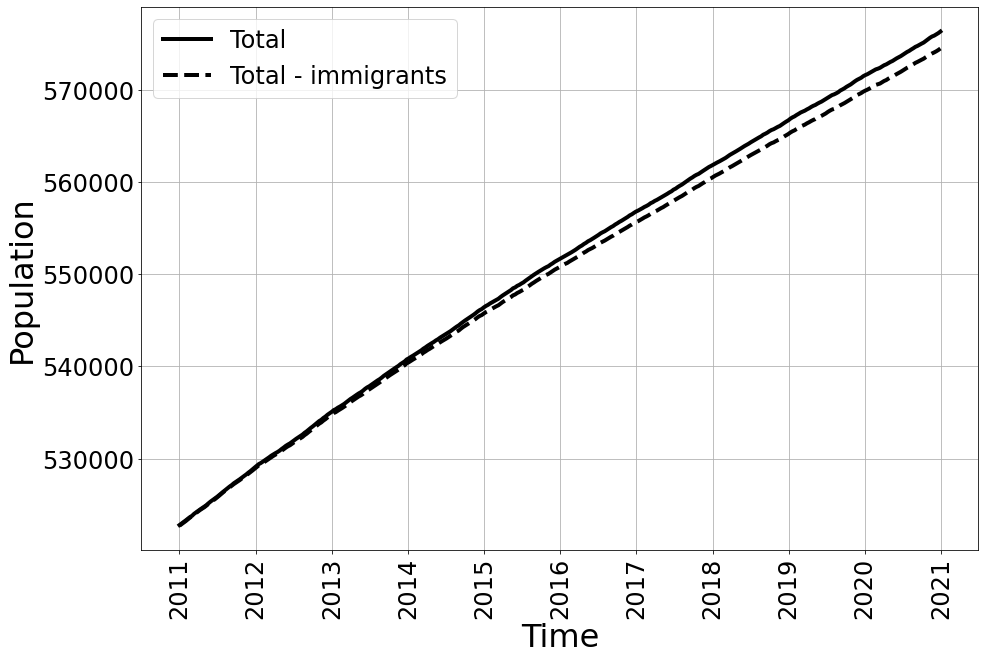

In [31]:
plt.figure(figsize=(15, 10))

plt.plot(time_axis, curr_pop_axis - left_pop_axis, 
         c='k', lw=4, 
         #marker="o",
         label="Total"
        )

plt.plot(time_axis, curr_pop_axis - dead_pop_axis - immg_pop_axis, 
         c='k', lw=4, ls='--', 
         #marker="o",
         label="Total - immigrants"
        )

plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

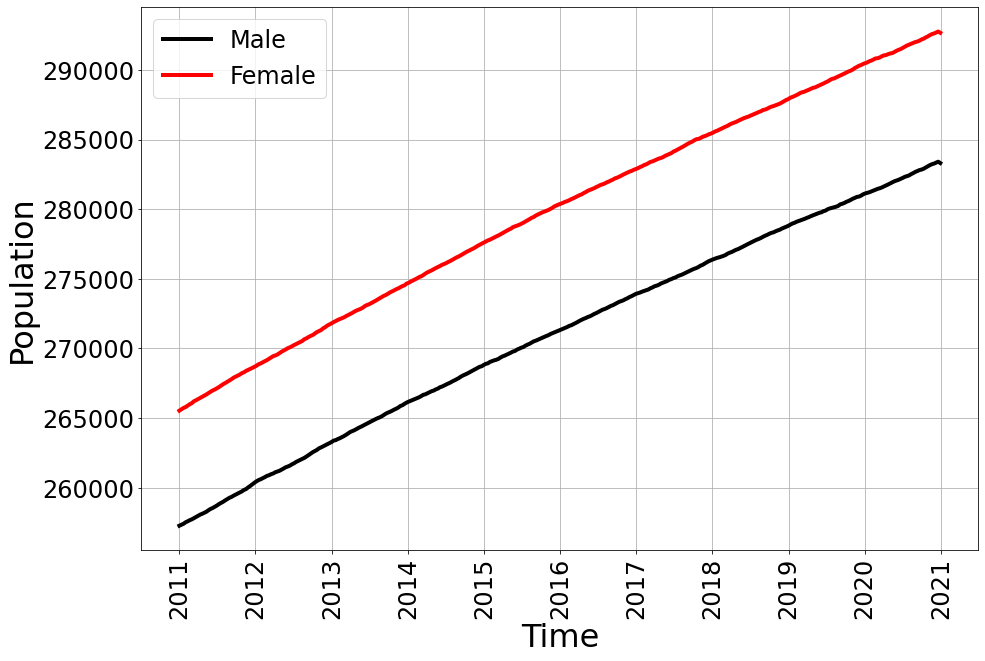

In [32]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, pop_M_axis, 
         c='k', lw=4, 
         #marker="o", 
         label="Male"
        )
plt.plot(time_axis, pop_F_axis, 
         c='r', lw=4, 
         #marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

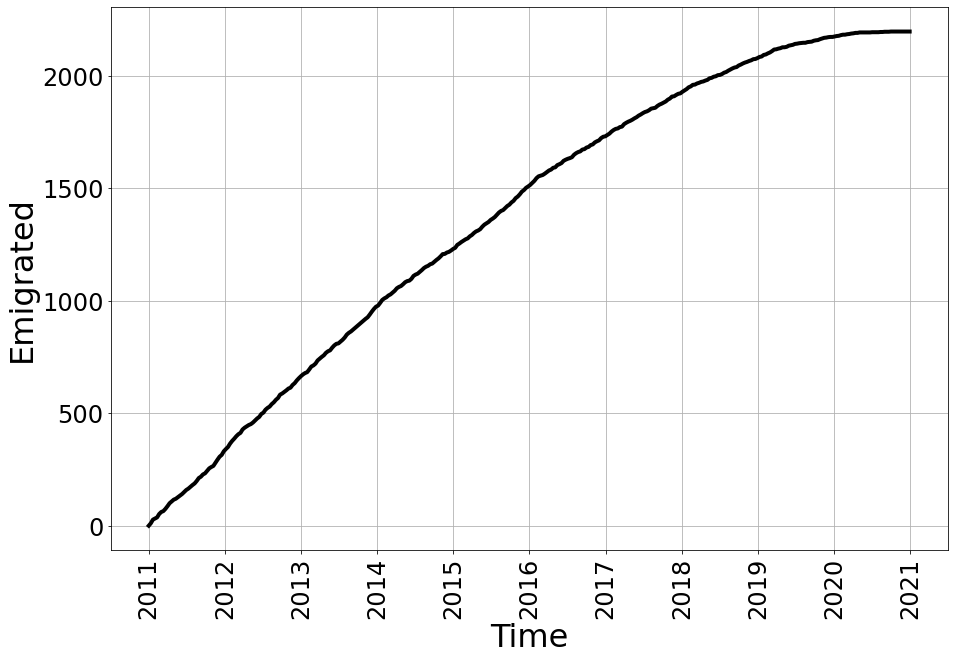

In [33]:
plt.figure(figsize=(15, 10))

# XXX Emigrated population has very high values in the first time step
plt.plot(time_axis, emig_pop_axis - emig_pop_axis[0], 
         c='k', lw=4
         #marker="o"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Emigrated", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

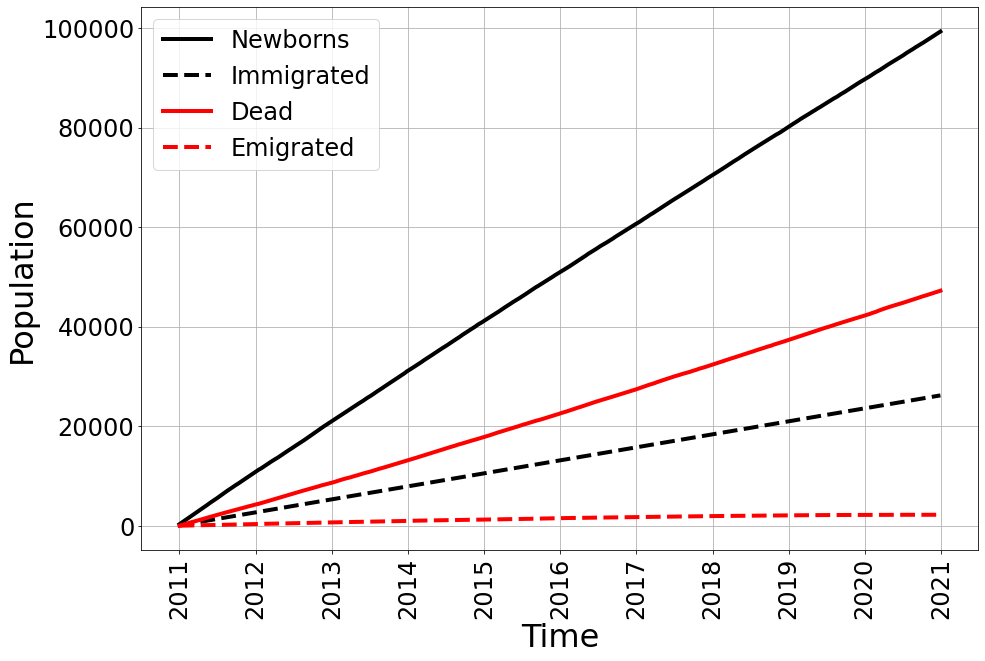

In [34]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis, new_babies_axis, 
         c='k', lw=4,
         #marker="o"
         label="Newborns"
        )

plt.plot(time_axis, immg_pop_axis, 
         c='k', lw=4, ls='--',
         #marker="o"
         label="Immigrated"
        )

plt.plot(time_axis, dead_pop_axis, 
         c='r', lw=4, 
         #marker="o"
         label="Dead"
        )

plt.plot(time_axis, emig_pop_axis - emig_pop_axis[0], 
         c='r', lw=4, ls='--',
         #marker="o"
         label="Emigrated"
        )

plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

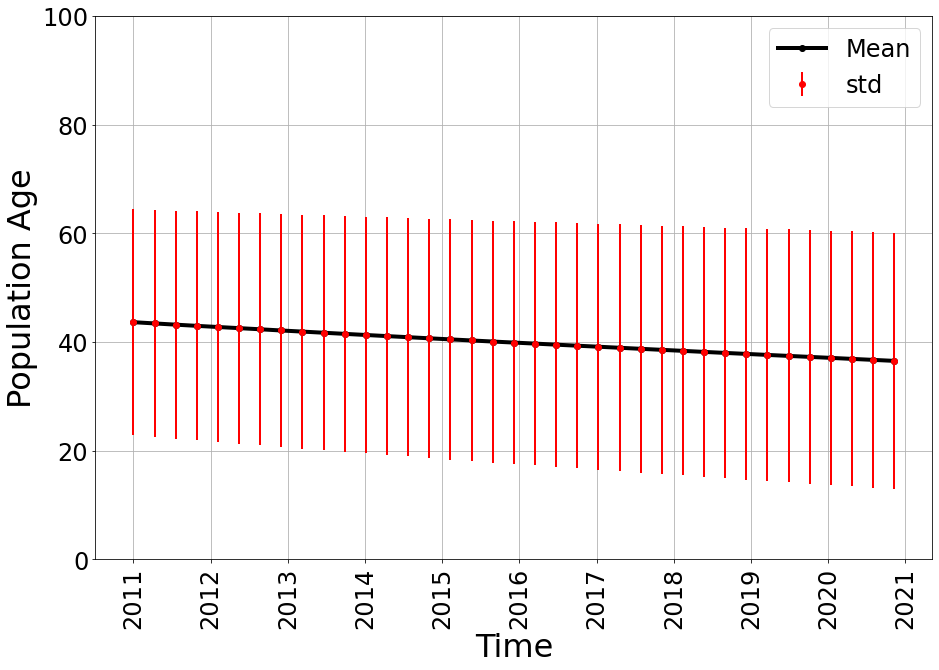

In [35]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis[::10], avg_age_axis[::10], 
         c='k', lw=4,
         marker="o",
         label="Mean")

plt.errorbar(time_axis[::10], avg_age_axis[::10], 
             yerr=std_age_axis[::10], 
             fmt='ro', lw=2,
             #marker="o"
             label="std"
            )

plt.xlabel("Time", size=32)
plt.ylabel("Population Age", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.ylim(0, 100)
plt.grid()
plt.legend(fontsize=24)
plt.show()

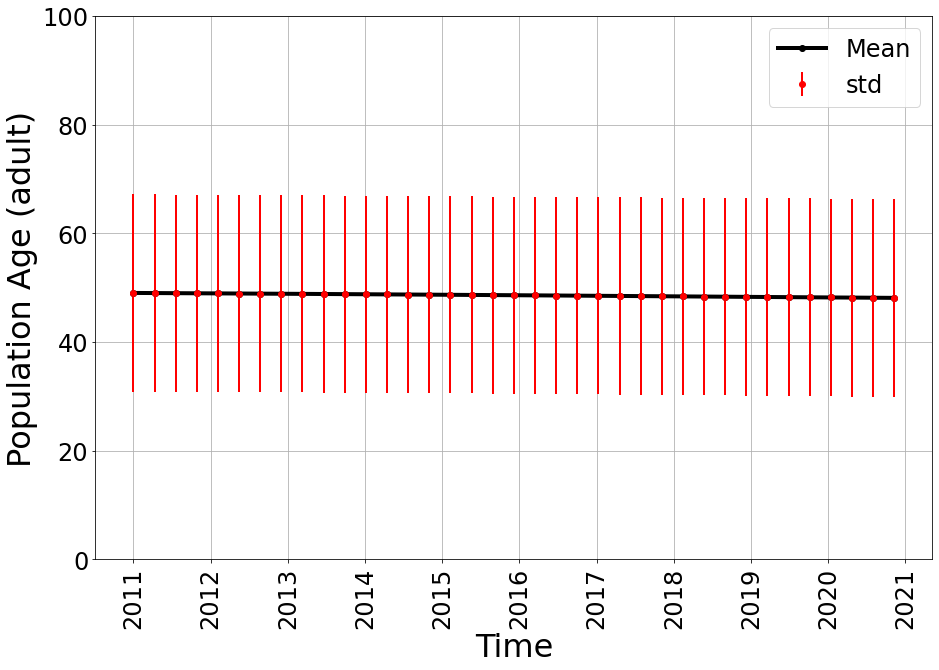

In [36]:
# Population (total)
plt.figure(figsize=(15, 10))

plt.plot(time_axis[::10], avg_age_adult_axis[::10], 
         c='k', lw=4,
         marker="o",
         label="Mean")

plt.errorbar(time_axis[::10], avg_age_adult_axis[::10], 
             yerr=std_age_adult_axis[::10], 
             fmt='ro', lw=2,
             #marker="o"
             label="std"
            )

plt.xlabel("Time", size=32)
plt.ylabel("Population Age (adult)", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.ylim(0, 100)
plt.grid()
plt.legend(fontsize=24)
plt.show()

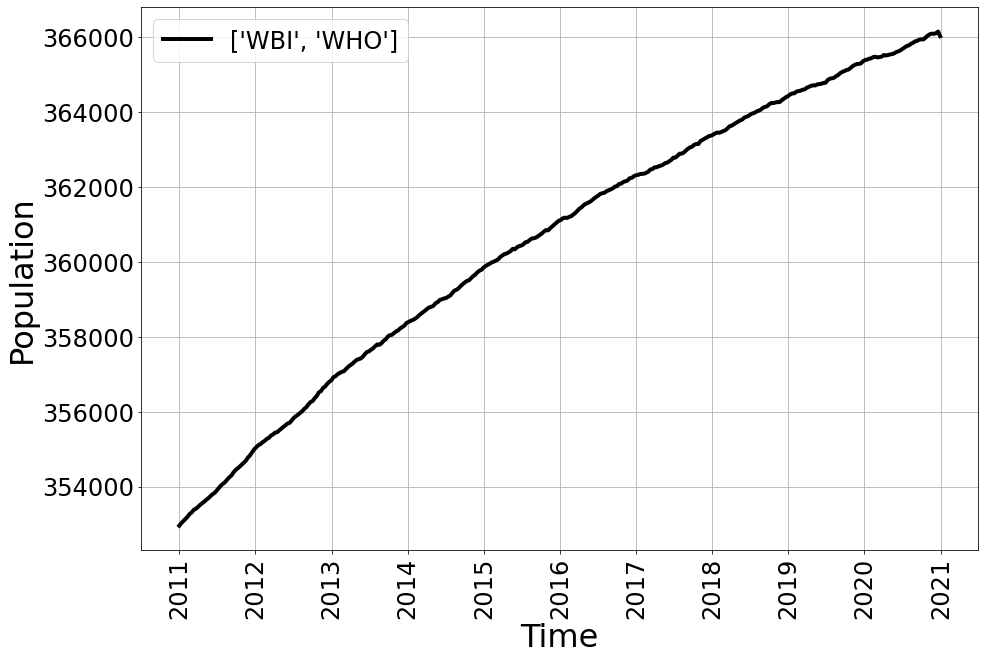

In [37]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, pop_ETH_axis, 
         c='k', lw=4, #marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [38]:
# only immigrants
pop_immig = pop[pop["immigrated"] == "Yes"]
#pop_immig = pop_immig[pop_immig["parent_id"] == -1]

In [39]:
pop["ethnicity"].value_counts()

WBI    389803
PAK    144252
WHO     25105
IND     20293
MIX     15338
BAN     14277
BLA     11454
OAS     10340
OTH      9492
BLC      4358
CHI      2604
OBL       215
Name: ethnicity, dtype: int64

In [40]:
pop_immig['ethnicity'].value_counts()

WHO    6388
BLA    5212
IND    4043
PAK    3942
WBI    2176
BAN    1097
OAS    1035
OTH     806
MIX     653
CHI     297
BLC     246
OBL     215
Name: ethnicity, dtype: int64

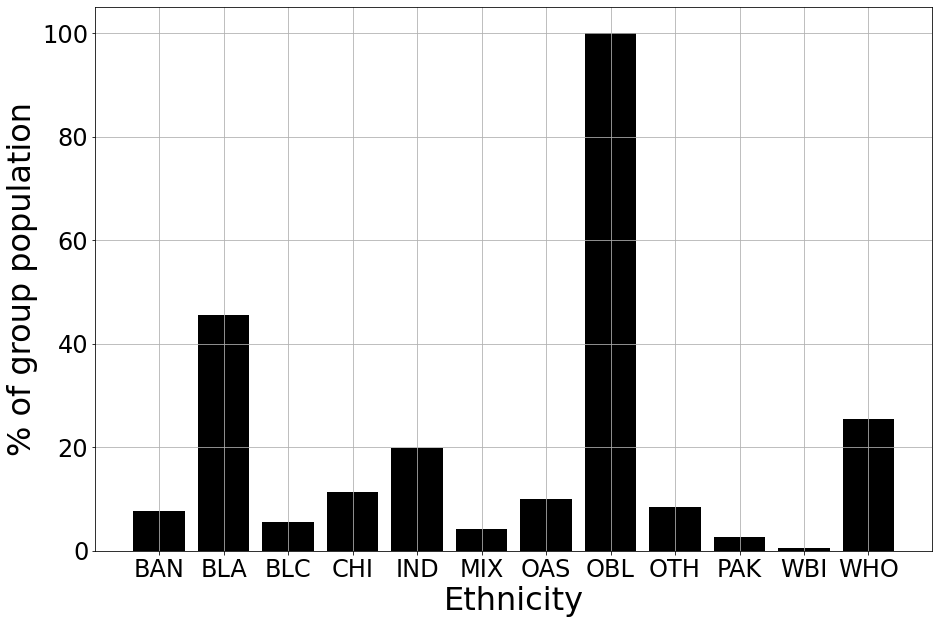

In [41]:
series2plot = pop_immig['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

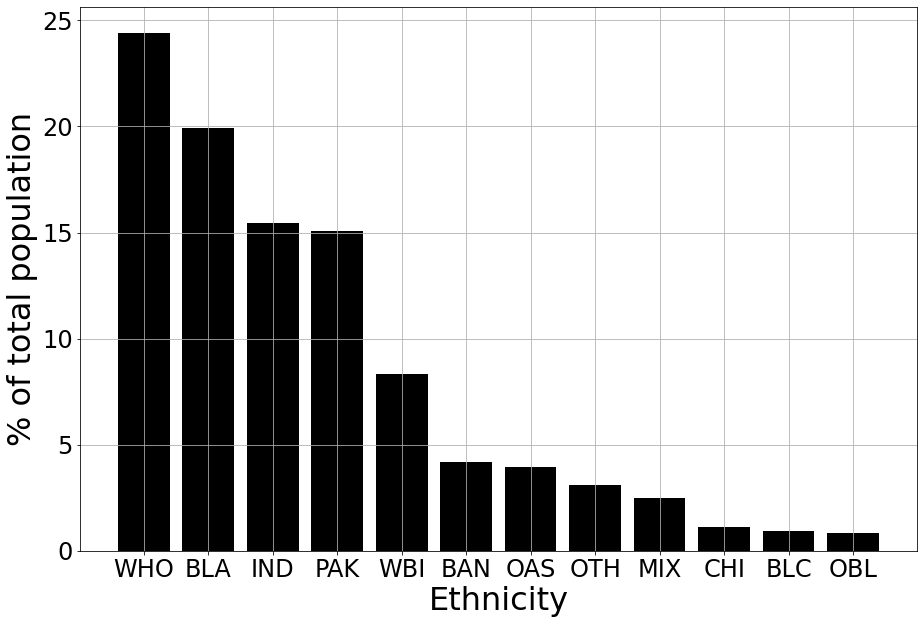

In [42]:
series2plot = pop_immig['ethnicity'].value_counts() / len(pop_immig["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of total population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

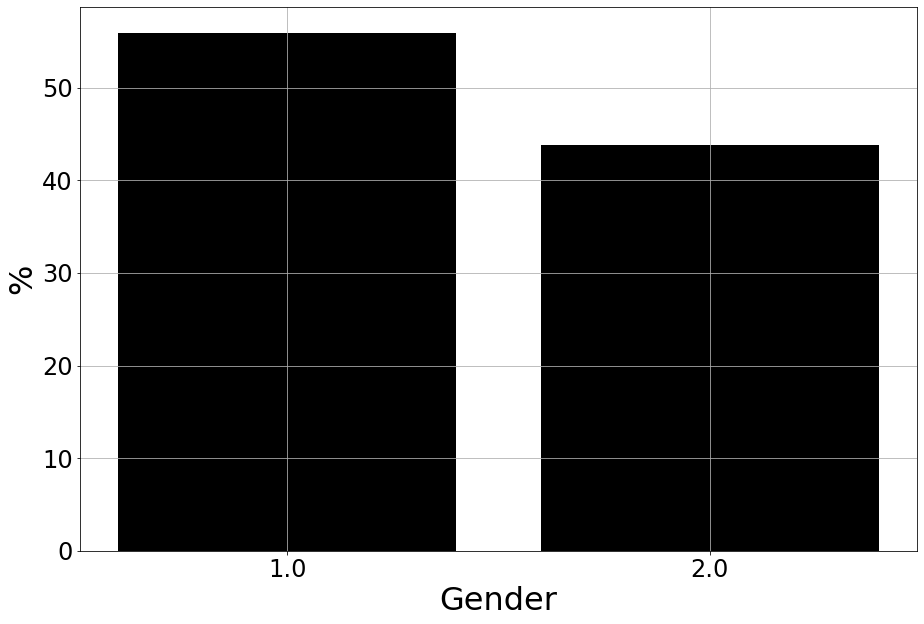

In [43]:
series2plot = pop_immig['sex'].value_counts() / len(pop_immig["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

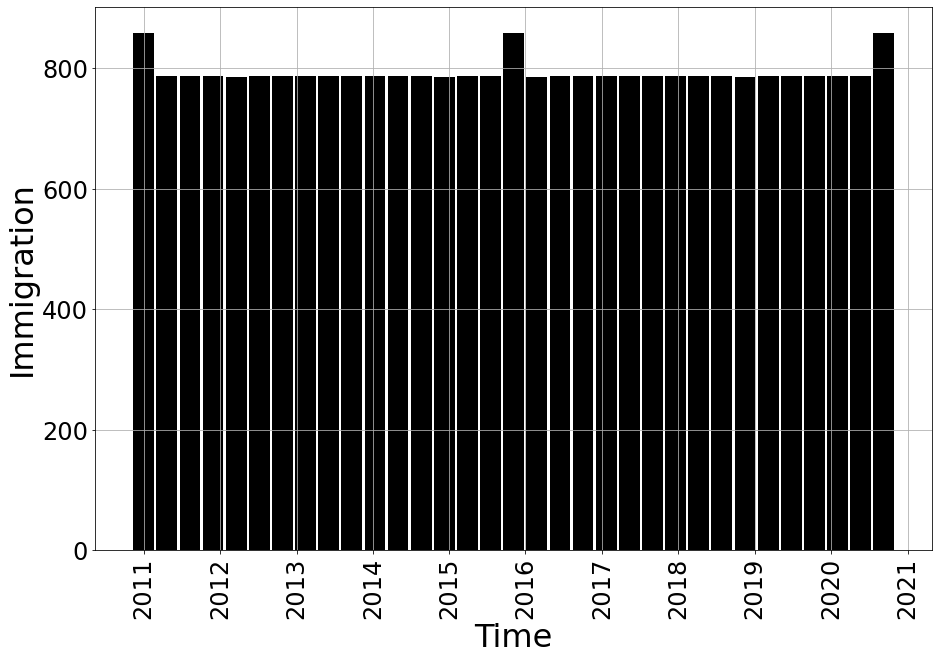

In [44]:
plt.figure(figsize=(15, 10))

pop_immig["entrance_time"].hist(bins=int((365*10)/110), 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Immigration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

In [45]:
pop

,tracked,years_of_life_lost,cause_of_death,immigrated,emigrated,ethnicity,age,sex,entrance_time,alive,location,exit_time,parent_id,last_birth_time
0,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
1,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
2,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
3,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
4,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
5,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
6,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
7,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
8,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
9,True,0.0,not_dead,no_immigration,no_emigration,WBI,11.027397,1.0,2010-12-22,alive,E09000002,NaT,-1,NaT
